In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import Xception
from tensorflow import keras
import tensorflow as tf
import os
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np

In [3]:
X = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

for layer in X.layers:
    layer.trainable = False

In [4]:
x = Flatten()(X.output)
X_out = Dense(2, activation='softmax')(x)

In [5]:
from keras.models import Model
model = Model(inputs=X.input, outputs=X_out)
#model.summary()

In [6]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.02),
    metrics=['accuracy'],
)

In [7]:
# Collecting Train Data

DATA_PATH = "../../my-datasets/Hurricane_Damage/train_another/"
CATEGORIES = ["damage", "no_damage"]

train_data_list = []

for category in CATEGORIES:
    dir_path = os.path.join(DATA_PATH, category)
    img_list = os.listdir(dir_path)
    class_num = CATEGORIES.index(category)
    print(f"Collecting from train_another/{category}/")
    for img_path in tqdm(img_list):
        if img_path.startswith(".ipynb_checkpoints", 0, len(img_path)):
            continue
        img = Image.open(os.path.join(dir_path, img_path))
        img_arr = np.array(img, dtype=int)
        if img_arr.shape[-1] == 4:
            img_arr = img_arr[...,:3]
        if img_arr.shape != (128, 128, 3):
            continue
        train_data_list.append([img_arr, class_num])
        
print(f"Total number of samples is {len(train_data_list)}")

100%|██████████| 5000/5000 [00:05<00:00, 923.81it/s]


100%|██████████| 5001/5001 [00:05<00:00, 924.91it/s]

Total number of samples is 10000


In [8]:
import random
random.shuffle(train_data_list)

X_train = []
y_train = []

for image, label in train_data_list:
    X_train.append(image)
    y_train.append(label)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape)
print(y_train.shape)

### Converting y into a one-hot vector ###
shape = (y_train.size, y_train.max()+1)
y_train_one_hot = np.zeros(shape)
rows = np.arange(y_train.size)
y_train_one_hot[rows, y_train] = 1

print(y_train_one_hot.shape)

(10000, 128, 128, 3)
(10000,)
(10000, 2)


In [9]:
# Collecting Test Data

DATA_PATH = "../../my-datasets/Hurricane_Damage/test/"
CATEGORIES = ["damage", "no_damage"]

test_data_list = []

for category in CATEGORIES:
    dir_path = os.path.join(DATA_PATH, category)
    img_list = os.listdir(dir_path)
    class_num = CATEGORIES.index(category)
    print(f"Collecting from test/{category}/")
    for img_path in tqdm(img_list):
        img = Image.open(os.path.join(dir_path, img_path))
        img_arr = np.array(img)
        test_data_list.append([img_arr, class_num])
        
print(f"Total number of samples is {len(test_data_list)}")

100%|██████████| 1000/1000 [00:00<00:00, 1240.66it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1097.26it/s]

Total number of samples is 2000


In [10]:
import random
random.Random(30).shuffle(test_data_list)

X_test = []
y_test = []

for image, label in test_data_list:
    X_test.append(image)
    y_test.append(label)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(X_test.shape)
print(y_test.size)

### Converting y_test into a one-hot vector ###
shape = (y_test.size, y_test.max()+1)
y_test_one_hot = np.zeros(shape)
rows = np.arange(y_test.size)
y_test_one_hot[rows, y_test] = 1

(2000, 128, 128, 3)
2000


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "archive/Xception_model/Xception_damage_classification.ckpt"
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True
    ),
]

# This line below must be commented when running this cell for the first time
model.load_weights(checkpoint_path)

model_history = model.fit(
    x=X_train,
    y=y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    batch_size=16,
    epochs=1,
    verbose=1,
    callbacks=callbacks_list
) 

2022-02-04 07:02:19.763562: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-02-04 07:02:23.529415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


625/625 [==============================] - 26s 29ms/step - loss: 75.6340 - accuracy: 0.8947 - val_loss: 237.5973 - val_accuracy: 0.8045


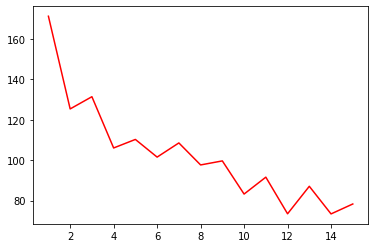

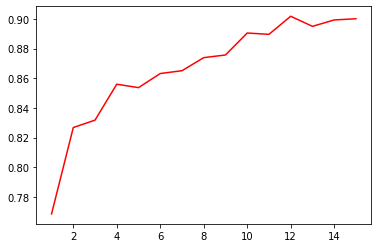

In [18]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.array(model_history.history['loss'])

val_loss = np.array(model_history.history['val_loss'])

train_acc = np.array(model_history.history['accuracy'])

val_acc = np.array(model_history.history['val_accuracy'])

epochs = np.arange(1, train_acc.size+1)

plt.plot(epochs, train_loss, 'r',)
plt.show()
plt.plot(epochs, train_acc, 'r',)
plt.show()

In [ ]:
checkpoint_path = "archive/Xception_model/Xception_damage_classification.ckpt"

X = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = Flatten()(X.output)
X_out = Dense(2, activation='softmax')(x)
new_model = Model(inputs=X.input, outputs=X_out)

new_model.load_weights(checkpoint_path)

In [ ]:
path = "../../my-datasets/Hurricane_Damage/test/damage/-93.65936500000001_30.138793.jpeg"
test_img = Image.open(path)
test_arr = np.asarray(test_img)
test_arr = np.expand_dims(test_arr, axis=0) 
pred = new_model.predict(x=test_arr)
print(pred)
test_img

In [ ]:
pred_ = np.argmax(pred, axis=1)
if(pred_ == 0):
    print("Hello")